# Introduction 

### 1. Set Up for Retrieving Data from the Marvel API 
- Import needed libraries and modules
- Set up API Keys and hash key for the Marvel API 

In [643]:
# for importing my API key 
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
from apikeys import API_KEY_PRIVATE
from apikeys import API_KEY_PUBLIC

# libraries for data analysis
import numpy as np 
import pandas as pd
import requests
import time
from bokeh.io import show, output_file
from bokeh.plotting import figure

In [5]:
# creating hash key needed for Marvel's API requests 
from hashlib import md5
import time 

ts = str(time.time())
combined = ''.join([ts, API_KEY_PRIVATE, API_KEY_PUBLIC])
hash_value = md5(combined.encode('ascii')).hexdigest()

### 2. Functions Needed for Retrieving Data 

#### 2a. Searching for Individual Character Information
- Functions will retrieve character information based on a character search (i.e., searching for Spider-Man, Wolverine, Avengers, etc.) 

In [327]:
def get_characterInfo(character_name):
    """Takes a character's name (should be spelled correctly) and retrieves and returns that character's ID."""
    
    params = {'ts': ts, 'apikey': API_KEY_PUBLIC, 'hash': hash_value, 'name':character_name} # set the parameters for the API
    
    response = requests.get('https://gateway.marvel.com:443/v1/public/characters', params = params) # searching for the provided character
    response_json = response.json()
    
    # use TRY and EXCEPT to determine whether or not the provided character name is valid (returned results)
    try:
        char_dict = {} # set character dictionary 
        response_data = response_json['data']['results'][0] # set variable name so bottom code looks cleaner 
        data_variables = ['id', 'name', 'description', 'resourceURI']
        
        for key in data_variables:
            char_dict[key] = response_data[key] 
        
        char_dict['thumbnail'] = response_data['thumbnail']['path']
        char_dict['thumbnail_ext'] = response_data['thumbnail']['extension']
        char_dict['char_comic_count'] = response_data['comics']['available']
        char_dict['char_series_count'] = response_data['series']['available']
        char_dict['comics_url'] = response_data['urls'][0]['url']
        char_dict['wiki_url'] = response_data['urls'][1]['url']
        
        time.sleep(np.random.randint(1,3))
        return char_dict
    
    except:
        print('{} is an invalid character name.'.format(character_name))
        return 999

In [195]:
def get_multiCharacterInfo(char_list):
    """Takes a list of character names and will use get their character info. Will convert dictionary information
    into a dataframe. Returns a dataframe."""
    
    # list comprehension for character info dictionary
    # will not add info to list if function returns 999 (meaning not a valid/searchable character)
    multi_char_info = [char_info for char_info in (get_characterInfo(char) for char in char_list) if char_info != 999]
    
    # convert to dataframe 
    char_df = pd.DataFrame(multi_char_info)
    
    return char_df 

#### 2b. Functions for Getting Comic Series Information for a Character
*NOTE: These were used for my own initial exploration of the API; these were not used for the final parts of this assignment. Section 2b contains most of the functions used in this assignment.* 
- This is specifically for retrieving comic series information (not to be confused with information for individual comics).


In [52]:
def get_characterSeries(char_id):
    """Takes a character's ID and returns all of the comic series that the character has been in."""
    
    # set initial offset number 
    offset = 0
    
    # creating a count for tracking # of times requests have been sent to the API 
    req_count = 0
    
    # Pull the initial 100 series of the character; outside of loop as to retrieve initial count of series 
    params = {'ts': ts, 'apikey': API_KEY_PUBLIC, 'hash': hash_value, 'orderBy':'startYear', 'limit':100, 'offset':offset} # setting params
    response = requests.get('https://gateway.marvel.com:443/v1/public/characters/{}/series?'.format(char_id), params = params) # end point for a character's series
    json_response = response.json()
    
    req_count += 1 # uptick count
    
    char_series_count = json_response['data']['total'] # getting the total number of series with the character
    response_result_count = json_response['data']['count'] # getting the total number of returned results (100 every time, unless returned results <100)
    
    # append all of the series info into 1 list 
    total_series_list = []
    total_series_list.extend(json_response['data']['results'])
    
    offset += response_result_count
    
    # while loop: as long as the number of responses we have is less than the total number of series, then we keep requesting for the next 100 results
    while offset < char_series_count:
        params = {'ts': ts, 'apikey': API_KEY_PUBLIC, 'hash': hash_value, 'orderBy':'startYear', 'limit':100, 'offset':offset}
        response = requests.get('https://gateway.marvel.com:443/v1/public/characters/{}/series?'.format(char_id), params = params)
        json_response = response.json()
        
        req_count += 1 # uptick count
        
        response_result_count = json_response['data']['count'] # getting the total number of returned results (100 every time, unless returned results <100)
        total_series_list.extend(json_response['data']['results'])
        
        offset += response_result_count
        
        time.sleep(0.5)
    
    print('Number of requests made: {}'.format(req_count))
    return total_series_list

In [20]:
def get_seriesInfo(comic_series, col_header_list=1):
    """Takes a list of dictionaries that contains a character's comic's series information (the output from 
    the get_CharacterSeries function) and returns a list of lists containing the following information:
    a series' id, title, description, start and end year, and type.
    Takes a list as a second argument. List should be keys from the dictionary of appropriate information.
    Used for creating a comic series dataframe."""
    
    if col_header_list == 1:
        col_header_list = ['id', 'title', 'description', 'startYear', 'endYear', 'type', 'resourceURI']
    else:
        col_header_list = col_header_list
    
    series_info_list = [] # initialize empty list 
    
    for idx in range(len(comic_series)): # iterate through the list of dictionaries 
        # use a list comprehension to get the correct keys (id, title, desc, etc.) from the dictionary and append to overall list
        series_info_list.append([comic_series[idx][key] for key in col_header_list])
     
    return series_info_list

In [128]:
def get_seriesCharacters(comic_series):
    """Takes a list of dictionaries (comic_series) and returns a list of lists. Each item in the list is 
    the comic series' ID, associated character, and the API URI link for that character. 
    The returned list of lists will be used for a comic series characters dataframe. The URI link will be used for 
    extracting each character's ID and can be used for further web scraping. 
    NOTE: comic_series (list of dictionaries returned from get_characterSeries function) returns only twenty
    characters per each comic series (i.e., a series may have 43 characters appear in that series, but only 20 
    character results are returned). Therefore data is complete through this endpoint."""
    
    total_char_info_list = [] # create whole list 
    for idx in range(len(comic_series)): # get index for each item in comic_series
        for item in comic_series[idx]['characters']['items']: # iterate through each series' character items
            char_info_list = [comic_series[idx]['id'], item['name'], item['resourceURI']] # get the comic series ID, char name, and char URI link
            total_char_info_list.append(char_info_list)
    
    return total_char_info_list 

#### 2c. Functions for Getting Individual Comic Information for a Character
- This is specifically for retrieving all of the individual comics that a chracter has appeared in. This is defined as comics that feature the character. 
- These functions are the primary functions used for this assignment. 

*Note: This will require more requests from the Marvel API. 
User may be rate limited as Marvel only allows 3000 requests per day.* 

In [596]:
def get_characterComics(char_id):
    """Takes a character's ID and returns all of the individual comics that the character has been in."""
    
    # set initial offset number 
    offset = 0
    
    # creating a count for tracking # of times requests have been sent to the API 
    req_count = 0
    
    # Pull the initial 100 comics of the character; outside of loop as to retrieve initial count of series 
    params = {'ts': ts, 'apikey': API_KEY_PUBLIC, 'hash': hash_value, 'orderBy':'onsaleDate', 'limit':100, 'offset':offset} # setting params
    response = requests.get('https://gateway.marvel.com:443/v1/public/characters/{}/comics'.format(char_id), params = params) # searching for the provided character
    # print(response) # print the API request results to see if any errors are returned
    json_response = response.json()
    
    req_count += 1 # uptick count
    
    char_comics_count = json_response['data']['total'] # getting the total number of comics with the character
    response_result_count = json_response['data']['count'] # getting the total number of returned results (100 every time, unless returned results <100)
    
    # append all of the series info into 1 list 
    total_comics_list = []
    total_comics_list.extend(json_response['data']['results'])
    
    offset += response_result_count
    
    # while loop: as long as the number of responses we have is less than the total number of series, then we keep requesting for the next 100 results
    while offset < char_comics_count:
        # using TRY and EXCEPT so that if a request returns an error, rerun the request until all results are returned 
        # (I typically encountered a 500 internal server error)
        try:
            params = {'ts': ts, 'apikey': API_KEY_PUBLIC, 'hash': hash_value, 'orderBy':'onsaleDate', 'limit':100, 'offset':offset} 
            response = requests.get('https://gateway.marvel.com:443/v1/public/characters/{}/comics'.format(char_id), params = params) 
            # print(response) # print the API request results to see if any errors are returned
            json_response = response.json()

            req_count += 1 # uptick count

            response_result_count = json_response['data']['count'] # getting the total number of returned results (100 every time, unless returned results <100)
            total_comics_list.extend(json_response['data']['results'])

            offset += response_result_count
            #time.sleep(np.random.randint(2,8)) # random sleep times as to not be rate limited 
            time.sleep(0.5)
        except:
            continue
    
    print('Number of requests made: {}'.format(req_count))
    return total_comics_list

In [422]:
def get_comicsInfo(comics, char_id, col_header_list=1):
    """Takes a list of dictionaries that contains a character's comic information (the output from 
    the get_CharacterComics function) and returns a list of lists containing the following information:
    a comic's id, title, issue number, description, series, the date the comic was on sale.
    Takes a list as a second argument. List should be keys from the dictionary of appropriate information.
    Used for creating a comic series dataframe.
    col_header_list argument is for the option of modifying desired fields to retrieve from the list of dictionaries."""
    
    if col_header_list == 1:
        col_header_list = ['id', 'title', 'issueNumber', 'resourceURI', 'description']
    else:
        col_header_list = col_header_list
    
    comics_info_list = [] # initialize empty list 
    
    for idx in range(len(comics)): # iterate through the list of dictionaries 
        temp_dict = {key:comics[idx][key] for key in col_header_list} # dict comprehension to get basic information (as indicated by the col_header_list)
        temp_dict['seriesURI'] = comics[idx]['series']['resourceURI'] # get the series that the comic belongs to 
        temp_dict['onsaleDate'] = comics[idx]['dates'][0]['date'] # get the original onsale date of the comic
        temp_dict['char_id'] = char_id
        comics_info_list.append(temp_dict)
        
    return comics_info_list

In [133]:
def get_comicCharacters(comics):
    """Takes a list of dictionaries of individual comic information and returns a list of dicts. 
    Each item in the dictionary contains the comic's ID, associated character, and the API URI link for that character.
    The individual comic endpoint returns all of the characters that appeared in that comic, creating a more 
    complete dataset."""
    
    total_char_info_list = [] # create whole list of character information
    
    for idx in range(len(comics)): # iterate through list of dictionaries
        for item in comics[idx]['characters']['items']: # iterate through each comic's character items
            # creating temporary dictionary which will be added to the total list of character comics
            temp_dict = {}
            temp_dict['comic_id'] = comics[idx]['id']
            temp_dict['character'] = item['name']
            temp_dict['character_URI'] = item['resourceURI']
            total_char_info_list.append(temp_dict)
    
    return total_char_info_list 

In [427]:
def get_multiCharComics(char_ids):
    """Takes a list of character IDs and get the comic information for each character. 
    Returns a dataframe."""
    
    # empty lists to store many results from get_comicsInfo and get_comicCharacters functions 
    comics_info = []
    char_info = []
    
    for char_id in char_ids:
        temp_comic_list = get_characterComics(char_id)
        temp_comic_info = get_comicsInfo(temp_comic_list, char_id)
        temp_char_info = get_comicCharacters(char_comic_list)
        
        comics_info.extend(temp_comic_info)
        char_info.extend(temp_char_info)
    
    # convert lists of dicts to DF 
    comics_df = pd.DataFrame(comics_info) 
    char_df = pd.DataFrame(char_info)
    
    
    return comics_df, char_df

# Final Manipulation of Dataframes

### 1. Get the initial character information 
- Retrieves character information for the top 25 Marvel characters from the past decade (as indicated by cbr.com). 
- After retrieving the character information dataframe, the dataframe is converted to a CSV file. 

*Note: I was unable to return any results for the 'War Machine' character.*

In [613]:
# top characters pulled from: https://www.cbr.com/best-marvel-heroes-decade/
top_characters = ['she-hulk (jennifer walters)','fantastic four','ant-man (scott lang)','storm','daredevil',
                  'captain marvel (carol danvers)','black widow',
                  'falcon','winter soldier','runaways','luke cage',
                  'hawkeye','thor','guardians of the galaxy','ms. marvel (kamala khan)','squirrel girl','hulk',
                  'spider-man (miles morales)','deadpool','black panther','wolverine','iron man',
                  'captain america','spider-man']

In [614]:
char_df = get_multiCharacterInfo(top_characters)

In [330]:
# Save the dataframe as a CSV file for future use
char_df.to_csv('character_info.csv')

# get a list of character ids
char_ids = list(char_df['id'])

### 2. Get all character comics 
- Requesting 20+ character's comics from the API was a lengthy process; as such I saved the results as CSV files (steps below)

In [353]:
# Note: pulling a large list of comic book characters will require many requests from the API and will take 
# comics_df, char_df = get_multiCharComics(char_ids)
# comics_df.to_csv('total_comics.csv')
# char_df.to_csv('total_characters.csv')

In [619]:
# I saved the requested data as CSV files; reading the files back for analysis
char_info_df = pd.read_csv('character_info.csv') # contains basic information for each character (1 row per character)
comics_df  = pd.read_csv('total_comics.csv') # contains all comics that features a character (1 row per comic per character)
chars_df = pd.read_csv('total_characters.csv') # contains all characters that appear within a comic

In [721]:
# create a copy as to not alter the original
comics_df1 = comics_df.copy()

### 3. Cleaning Data
- After retrieving the data from the API, the next part is to clean up some of the data in the dataframes. This may include cleaning up some of the date fields, combining certain columns together, etc.

In [ ]:
# rename id column to char_id
char_info_df.rename(columns={'id':'char_id'}, inplace=True)

In [641]:
# combining the char_info_df thumbnail and thumbnail_ext columns to have a full link (add on the extention to end of link)
char_info_df["thumbnail_link"] = char_info_df["thumbnail"] + "."+ char_info_df["thumbnail_ext"]
char_info_df.drop(['thumbnail', 'thumbnail_ext'], axis=1, inplace=True)

print("{}'s image link: {}".format(char_info_df['name'][23],char_info_df['thumbnail_link'][23]))

Spider-Man's image link: http://i.annihil.us/u/prod/marvel/i/mg/3/50/526548a343e4b.jpg


In [724]:
# Removing rows where there is a missing character ID (these rows also happened to have all NaN values)
nan_idx = comics_df1[comics_df1['char_id'].isna()].index
comics_df1.drop(comics_df1.index[nan_idx], inplace=True)

In [748]:
# remove rows where the characters ID don't matched the original list of character IDs
# some of the requested results had a different dictionary structure, resulting in NaN rows and incorrect data
# some data returned no values 
comics_df1 = comics_df1[comics_df1.char_id.isin(char_ids)]

In [764]:
# converting onsaleDate column to actual date
comics_df1['date'] = comics_df1['onsaleDate'].str[:10] # select first 10 characters of the string as the date
# if first 10 characters weren't a valid date, then coerce value as NaT (non parseable date)
# example of invalid date: '-0001-11-30'
comics_df1['date'] = pd.to_datetime(comics_df1['date'], errors='coerce') 

In [784]:
comics_df1 = pd.merge(comics_df1, char_info_df, on='char_id')

In [786]:
comics_df1.columns

Index(['char_id', 'description_x', 'id', 'issueNumber', 'onsaleDate',
       'resourceURI_x', 'seriesURI', 'title', 'date', 'char_comic_count',
       'char_series_count', 'comics_url', 'description_y', 'name',
       'resourceURI_y', 'wiki_url', 'thumbnail_link'],
      dtype='object')

### 4. Plotting Data

#### Plotting Number of Comics per Character

In [941]:
# Bar plot of number of comic counts for each character
output_file("char_counts.html")

sorted_char_info = char_info_df[['name', 'char_comic_count', 'thumbnail_link']].sort_values(['char_comic_count'], ascending=False)

char_names = list(sorted_char_info['name'])
comic_count = list(sorted_char_info['char_comic_count'])
thumbnails = list(sorted_char_info['thumbnail_link'])

data = {'char_names': char_names,
       'comic_count': comic_count,
       'thumbnails': thumbnails}

# adding hover details (hovering over a bar will display character and their number of comics)
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@thumbnails" height="42" alt="@thumbnails" width="42"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="1"
            ></img>
        </div>
        <div>
            <span style="font-size: 11px; font-weight: bold;">@char_names</span>
        </div>
        <div>
            <span style="font-size: 10px; color: #4c333;">Comic Count: @comic_count</span>
        </div>
    </div>
"""

p = figure(x_range=char_names, plot_height=500, plot_width=800, title="Number of Comics Per Character",
           toolbar_location=None, tooltips=TOOLTIPS)

p.vbar(x='char_names', top='comic_count', width=0.8, source=data)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.major_label_orientation = np.pi/4
p.y_range.start = -30

show(p)

#### Plotting Number of Comics per Year per Character
Selected characters are as follows: 
- 'Black Panther'
- 'Captain America'
- 'Deadpool'
- 'Hulk'
- 'Iron Man'
- 'Spider-Man'
- 'Spider-Man (Miles Morales)'
- 'Wolverine'

In [808]:
# Grouping comics dataframe by character name and year of comic (get count per year)
grped_count_comics_df = comics_df1.groupby(['name', comics_df1['date'].map(lambda x: x.year)]).count()
#grped_count_comics_df = pd.DataFrame(grped_count_comics_df['char_id']).rename(columns={'char_id':'count'})

In [915]:
top_chars = ['Black Panther', 'Captain America', 'Deadpool', 'Hulk', 
            'Iron Man','Spider-Man','Spider-Man (Miles Morales)', 'Wolverine']
# Filtering original dataset
top_grped_comics = grped_count_comics_df[grped_count_comics_df.index.get_level_values('name').isin(top_10_chars)]

In [918]:
# reducing the dataframe to 1 column
top_grped_comics = pd.DataFrame(top_grped_comics['char_id']).rename(columns={'char_id':'counts'})

In [919]:
# resetting the index (as the group by function had originally created indexes for each Character Name and Year)
top_grped_comics.reset_index(level=1, inplace=True)
top_grped_comics.reset_index(level=0, inplace=True)

In [940]:
# Plotting 
output_file("comic_counts_year.html")

p = figure(title="title", x_axis_label='yr', y_axis_label='y',plot_width=800, plot_height=500, x_range=(1940, 2030))

colors = ['#0097a7','#ffd54f','#7cb342','#ec407a','#3f51b5','#f44336','#330000','#0066FF','#006666','#424949','#873600'] # a list of interesting colors
color_index = 0

for name in top_chars:
    temp_df = top_grped_comics[top_grped_comics['name']==name]
    r = p.line(temp_df['date'], temp_df['counts'], line_width=2, alpha=0.8, color=colors[color_index],
               muted_alpha=0.2, legend=name)
    r.muted=True # muting each line so as to not have a messy graph
    color_index+=1

r.muted=False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.legend.location = "top_left"    
p.legend.click_policy="mute"

show(p)

## Creating Edge List from chars_df 

In [948]:
import itertools
import networkx as nx

In [961]:
G = nx.Graph()
G.add_nodes_from(chars_df['character'].values)

# Create edges 
for idx, group in chars_df.groupby(['comic_id'])['character']:
    # generate edge list combination based on comic_id groupings
    for char1, char2 in itertools.combinations(group, 2): # creating combinations of each character (no replacement)    
        G.add_edge(char1, char2)
        
#print(G.edges())

In [972]:
# displaying the characters with the highest degree (most connections with other characters)
sorted_char_deg = sorted(G.degree, key=lambda x: x[1], reverse=True)

In [967]:
nx_char_list = list(chars_df['character'].unique())

In [1007]:
degree_list = [G.degree(char) for char in nx_char_list]
degree_df = pd.DataFrame(degree_list, columns=['degree'])

In [1026]:
len(degree_df[degree_df['degree'] > 400])

11

In [1027]:
# 11 characters with more than 400 degrees (400 other connections)
pop_chars = [char for char in nx_char_list if G.degree(char) > 400]


In [1035]:
pop_chars_size = [G.degree(char)/2 for char in pop_chars]

ValueError: 'c' argument has 24 elements, which is not acceptable for use with 'x' with size 1036, 'y' with size 1036.

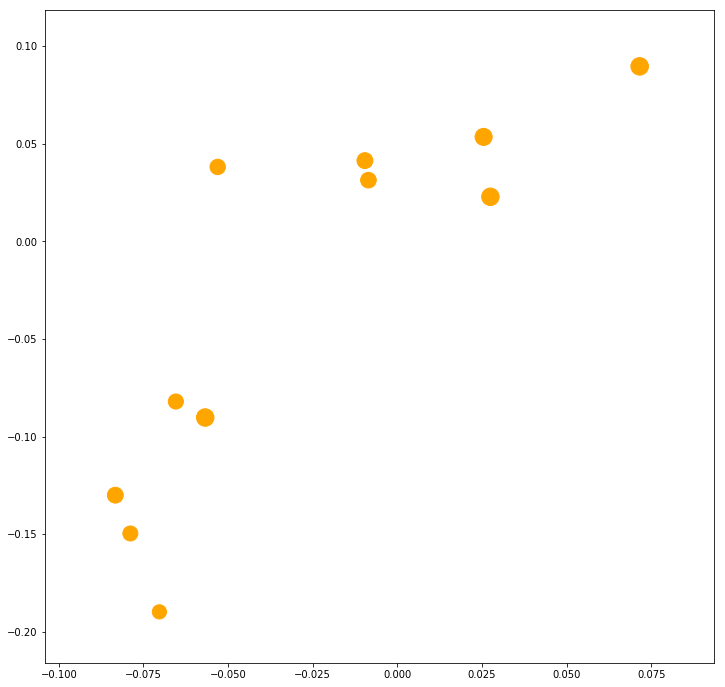

In [1046]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
layout = nx.spring_layout(G,iterations=50)

#nx.draw_networkx(G, layout, node_size=50, node_color='#BDC3C7', alpha=0.8, linewidths=0.3, with_labels=False)
nx.draw_networkx_nodes(G, layout, nodelist=pop_chars, node_color='orange', node_size=pop_chars_size, label=pop_chars)
pos = nx.spring_layout(G, iterations=200)
nx.draw(G, pos, node_color=range(24), node_size=50, cmap=plt.cm.Blues)

plt.show()


# Conclusions:

Overall, this final project demonstrated many of the skills and techniques learned in IMT/LIS 511 for Spring 2018. One of the more difficult tasks was learning a new API. Specifically, the Marvel API only returns a maximum of 100 results at a time making it difficult to have a comprehensive dataset. For example, Spider-Man has a total of 3601 comics, which would require 37 requests to the API. Additionally, when looping to keep requesting all of a character's data, I would often receive a code 500 error. To combat this, and not lose all the data that I had requested in the function, I implemented error handling (via Try/Exception) to keep requesting data again from the API if data wasn't pulled properly. 

Cleaning the data wasn't also an interesting task. For example, not all data was properly retrieved from the API (i.e., empty rows, improperly formatted rows, etc.). There were over 100 rows that had NaN values for all columns, which I ended up removing from the dataframe. I also needed to modify the date columns (for the comics), converting from string to date and selecting only the first few characters of the date string. 

Regarding the data visualizations: it was interesting to note that there was a dip in the number of comics for all the top characters around 2015. This could be attributed to the fact that Marvel comics relaunched in 2015 (https://en.wikipedia.org/wiki/All-New,_All-Different_Marvel). 

### Extras: 

- This section is a demonstration of the functions on a smaller list of characters (Doctor Strange and Thanos) 

In [593]:
# Running on smaller list of characters 
side_characters = ['doctor strange', 'thanos']
side_char_df = get_multiCharacterInfo(side_characters)
side_char_ids = list(side_char_df['id'])

In [601]:
comics_df2, char_df2 = get_multiCharComics(side_char_ids)